In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/SaltIdentification/

/content/drive/MyDrive/SaltIdentification


### Importing the Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm.auto import tqdm, trange
from itertools import chain

import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, Input, layers, callbacks, utils, optimizers
import random,os, sys
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

from sklearn.metrics import confusion_matrix


### Setting-up configuration for the Images

In [ ]:
class config:
    im_width = 128
    im_height = 128
    im_chan = 3
    path_train = 'train/'
    path_test = 'test/'

### Reading the Images

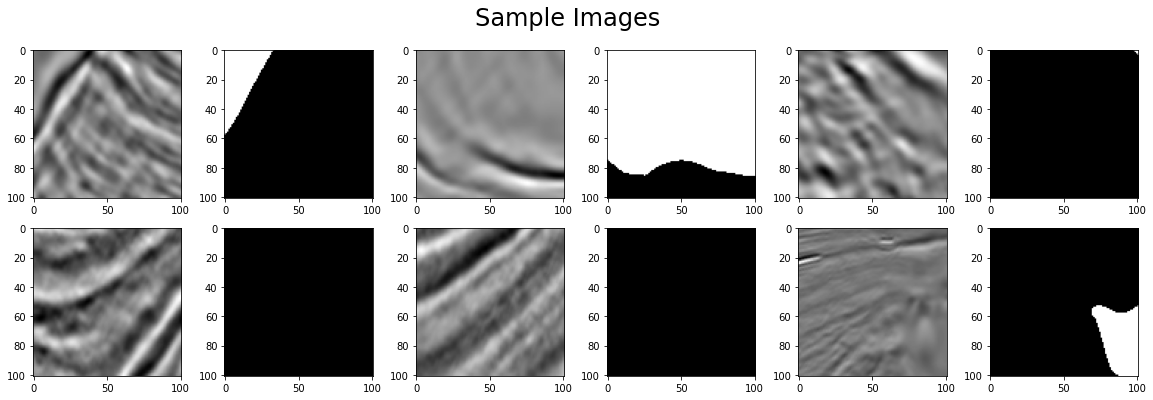

In [ ]:
random.seed(19)
ids = random.choices(os.listdir('train/images'), k=6)
fig = plt.figure(figsize=(20,6))
for j, img_name in enumerate(ids):
    q = j+1
    
    img = load_img('train/images/' + img_name)
    img_mask = load_img('train/masks/' + img_name)
    
    plt.subplot(2, 6, q*2-1)
    plt.imshow(img)
    plt.subplot(2, 6, q*2)
    plt.imshow(img_mask)
fig.suptitle('Sample Images', fontsize=24);

In [ ]:
train_ids = next(os.walk(config.path_train+"images"))[2]
#test_ids = next(os.walk(config.path_test+"images"))[2]

In [ ]:
X = np.zeros((len(train_ids), config.im_height, config.im_width, config.im_chan), dtype=np.uint8)
Y = np.zeros((len(train_ids), config.im_height, config.im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    x = img_to_array(load_img(config.path_train + '/images/' + id_, color_mode="grayscale"))
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X[n] = x
    mask = img_to_array(load_img(config.path_train + '/masks/' + id_, color_mode="grayscale"))
    Y[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

Getting and resizing train images and masks ... 



Done!
X shape: (4000, 128, 128, 3)
Y shape: (4000, 128, 128, 1)


### Data Augmentation

In [ ]:
X_train = X[:int(0.9*len(X))]
Y_train = Y[:int(0.9*len(X))]
X_eval  = X[int(0.9*len(X)):]
Y_eval  = Y[int(0.9*len(X)):]

X_train = np.append(X_train, [np.fliplr(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in Y], axis=0)
X_train = np.append(X_train, [np.flipud(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.flipud(x) for x in Y], axis=0)
# X_train = np.append(X_train, [np.rot90(x, k=1) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=1) for x in Y], axis=0)
# X_train = np.append(X_train, [np.rot90(x, k=3) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=3) for x in Y], axis=0)

del X, Y

print('X train shape:', X_train.shape, 'X eval shape:', X_eval.shape)
print('Y train shape:', Y_train.shape, 'Y eval shape:', Y_eval.shape)

X train shape: (11600, 128, 128, 3) X eval shape: (400, 128, 128, 3)
Y train shape: (11600, 128, 128, 1) Y eval shape: (400, 128, 128, 1)


In [ ]:
Y_eval=np.where(Y_eval==False, 0, Y_eval)
Y_train=np.where(Y_train==False, 0, Y_train)

### Normalizing the Images

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1
  return input_image, input_mask

### Creating Batches of Data

In [ ]:
@tf.function
def load_image_train(X_train,Y_train):
  input_image = tf.image.resize(X_train, (128, 128))
  input_mask = tf.image.resize(Y_train, (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
def load_image_test(X_train,Y_train):
  input_image = tf.image.resize(X_train, (128, 128))
  input_mask = tf.image.resize(Y_train, (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
X_train=tf.convert_to_tensor(
    X_train, dtype=tf.float32, dtype_hint=None, name=None
)

X_eval=tf.convert_to_tensor(
    X_eval, dtype=tf.float32, dtype_hint=None, name=None
)

Y_train=tf.convert_to_tensor(
    Y_train, dtype=tf.int8, dtype_hint=None, name=None
)

Y_eval=tf.convert_to_tensor(
    Y_eval, dtype=tf.int8, dtype_hint=None, name=None
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_eval,Y_eval))

In [ ]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### Function to display the Image and corresponding Mask

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

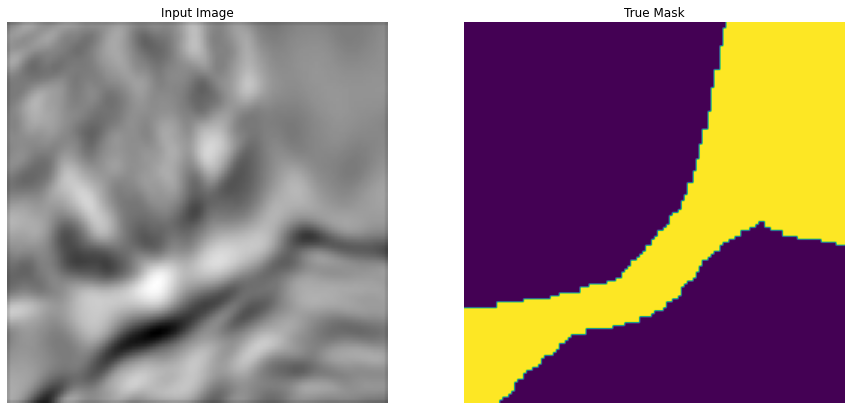

In [ ]:
for image, mask in train.take(6):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### Building the Model

### Pretrained MobileNetV2 Encoder as Downstack:

In [ ]:
OUTPUT_CHANNELS = 2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


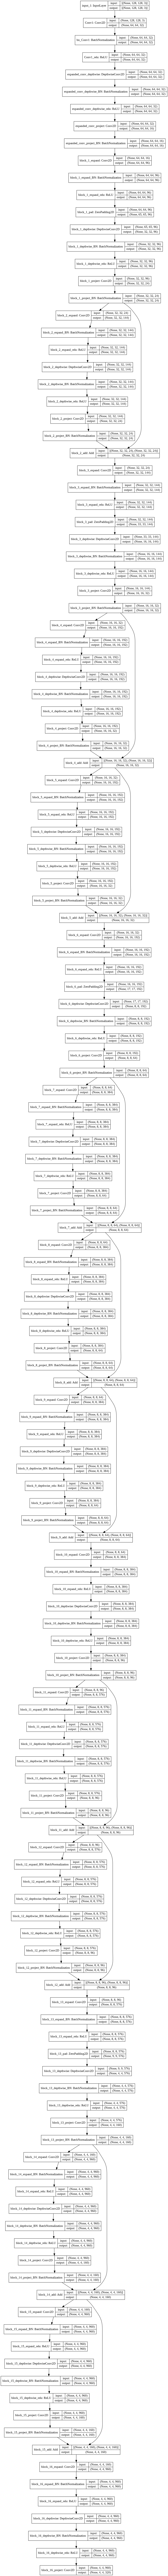

In [ ]:
tf.keras.utils.plot_model(down_stack, show_shapes=True)

### Up Stack:

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

### Building the U-Net style model from Down-Stack and Up-Stack

---



In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, activation="softmax", strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

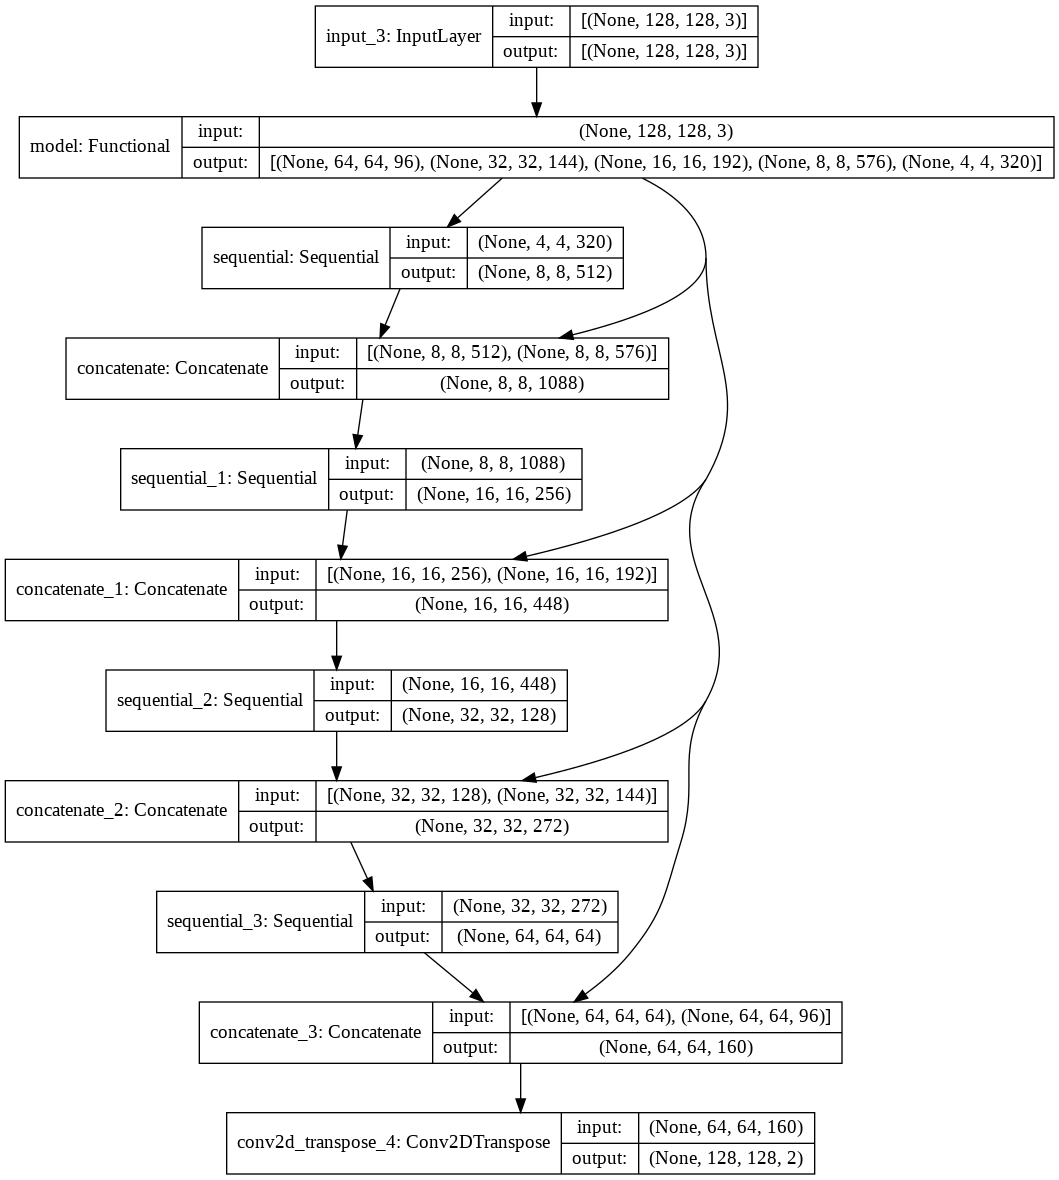

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Helper function to create Mask and show predictions

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

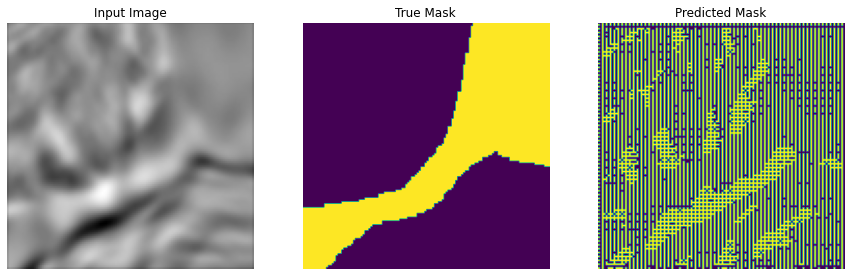

In [ ]:
show_predictions()

### Callback function to display the intermediate results:

In [ ]:
iou_history=[]
epoch_history=[]
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(epoch%5 ==0):
      #clear_output(wait=True)
      show_predictions()
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
      tn, fp, fn, tp=confusion_matrix(Y_eval.numpy().flatten(),np.expand_dims(np.argmax(model.predict(X_eval, verbose=1),axis=-1),axis=-1).flatten()).ravel()
      IOU=tp/(tp+fp+fn)
      iou_history.append(IOU)
      epoch_history.append(epoch)
      print('IOU Score after epoch'+ str(epoch)+" is "+ str(IOU))




### Training the model

Epoch 1/200
181/181 [==============================] - 30s 139ms/step - loss: 0.3661 - accuracy: 0.8405 - val_loss: 0.2854 - val_accuracy: 0.8905


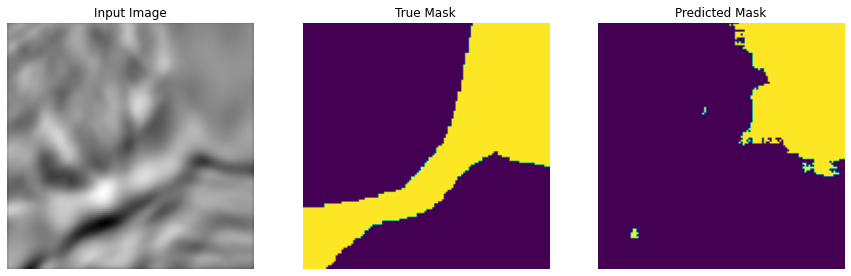


Sample Prediction after epoch 1

13/13 [==============================] - 1s 74ms/step
IOU Score after epoch0 is 0.00034286690343184837
Epoch 2/200
181/181 [==============================] - 25s 136ms/step - loss: 0.2377 - accuracy: 0.9056 - val_loss: 0.2317 - val_accuracy: 0.9079
Epoch 3/200
181/181 [==============================] - 25s 138ms/step - loss: 0.2197 - accuracy: 0.9127 - val_loss: 0.2371 - val_accuracy: 0.9066
Epoch 4/200
181/181 [==============================] - 25s 139ms/step - loss: 0.2104 - accuracy: 0.9159 - val_loss: 0.2244 - val_accuracy: 0.9101
Epoch 5/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1978 - accuracy: 0.9216 - val_loss: 0.2297 - val_accuracy: 0.9109
Epoch 6/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1909 - accuracy: 0.9231 - val_loss: 0.2225 - val_accuracy: 0.9147


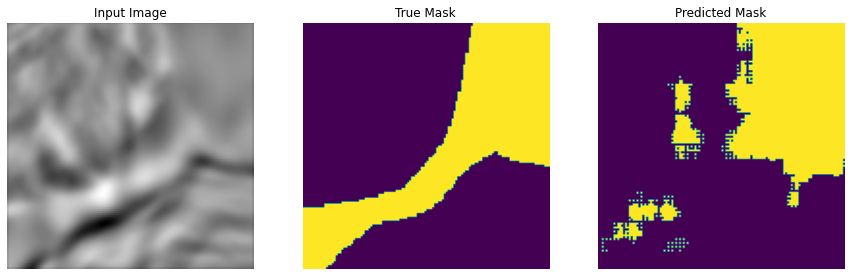


Sample Prediction after epoch 6

13/13 [==============================] - 1s 43ms/step
IOU Score after epoch5 is 0.023647236276396113
Epoch 7/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1954 - accuracy: 0.9218 - val_loss: 0.2200 - val_accuracy: 0.9129
Epoch 8/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1898 - accuracy: 0.9232 - val_loss: 0.2185 - val_accuracy: 0.9154
Epoch 9/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1782 - accuracy: 0.9287 - val_loss: 0.2192 - val_accuracy: 0.9189
Epoch 10/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1800 - accuracy: 0.9286 - val_loss: 0.2068 - val_accuracy: 0.9234
Epoch 11/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1725 - accuracy: 0.9303 - val_loss: 0.2112 - val_accuracy: 0.9199


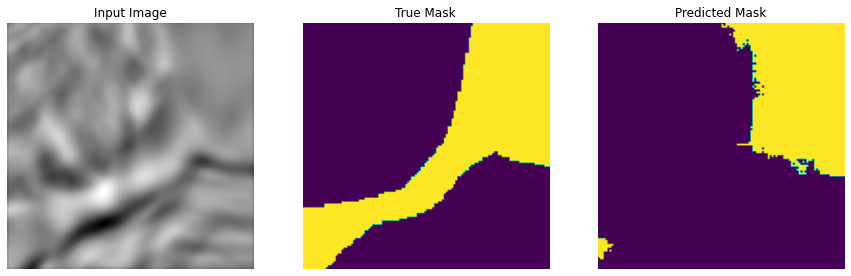


Sample Prediction after epoch 11

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch10 is 0.01312226948287535
Epoch 12/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1689 - accuracy: 0.9315 - val_loss: 0.2051 - val_accuracy: 0.9242
Epoch 13/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1621 - accuracy: 0.9348 - val_loss: 0.2127 - val_accuracy: 0.9198
Epoch 14/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1706 - accuracy: 0.9315 - val_loss: 0.1663 - val_accuracy: 0.9326
Epoch 15/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1666 - accuracy: 0.9326 - val_loss: 0.1781 - val_accuracy: 0.9273
Epoch 16/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1542 - accuracy: 0.9384 - val_loss: 0.1735 - val_accuracy: 0.9298


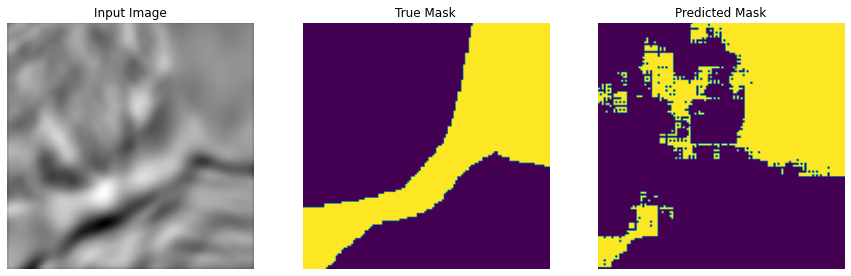


Sample Prediction after epoch 16

13/13 [==============================] - 1s 43ms/step
IOU Score after epoch15 is 0.00474642152023692
Epoch 17/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1537 - accuracy: 0.9378 - val_loss: 0.1709 - val_accuracy: 0.9272
Epoch 18/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1530 - accuracy: 0.9385 - val_loss: 0.1740 - val_accuracy: 0.9334
Epoch 19/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1476 - accuracy: 0.9403 - val_loss: 0.1690 - val_accuracy: 0.9342

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 20/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1411 - accuracy: 0.9427 - val_loss: 0.1525 - val_accuracy: 0.9368
Epoch 21/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1319 - accuracy: 0.9469 - val_loss: 0.1463 - val_accuracy: 0.9398


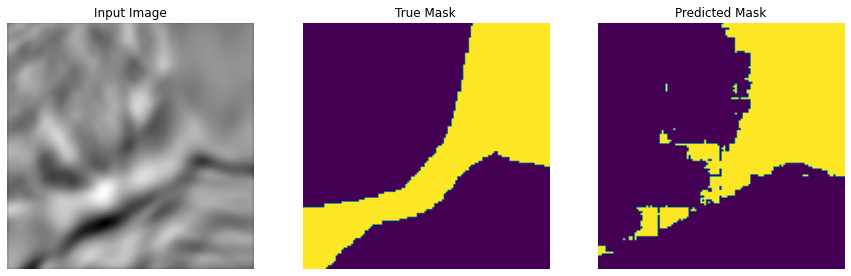


Sample Prediction after epoch 21

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch20 is 0.0037918503054202427
Epoch 22/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1300 - accuracy: 0.9475 - val_loss: 0.1463 - val_accuracy: 0.9395
Epoch 23/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1277 - accuracy: 0.9484 - val_loss: 0.1483 - val_accuracy: 0.9379
Epoch 24/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1258 - accuracy: 0.9493 - val_loss: 0.1432 - val_accuracy: 0.9399
Epoch 25/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1234 - accuracy: 0.9504 - val_loss: 0.1430 - val_accuracy: 0.9409
Epoch 26/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1221 - accuracy: 0.9514 - val_loss: 0.1437 - val_accuracy: 0.9404


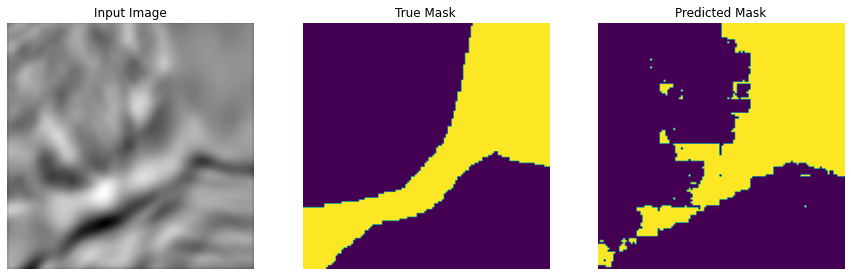


Sample Prediction after epoch 26

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch25 is 0.0038923570907743767
Epoch 27/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1263 - accuracy: 0.9486 - val_loss: 0.1444 - val_accuracy: 0.9413
Epoch 28/200
181/181 [==============================] - 25s 141ms/step - loss: 0.1194 - accuracy: 0.9517 - val_loss: 0.1434 - val_accuracy: 0.9414
Epoch 29/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1203 - accuracy: 0.9517 - val_loss: 0.1403 - val_accuracy: 0.9420
Epoch 30/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1212 - accuracy: 0.9512 - val_loss: 0.1473 - val_accuracy: 0.9395
Epoch 31/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1147 - accuracy: 0.9538 - val_loss: 0.1407 - val_accuracy: 0.9425


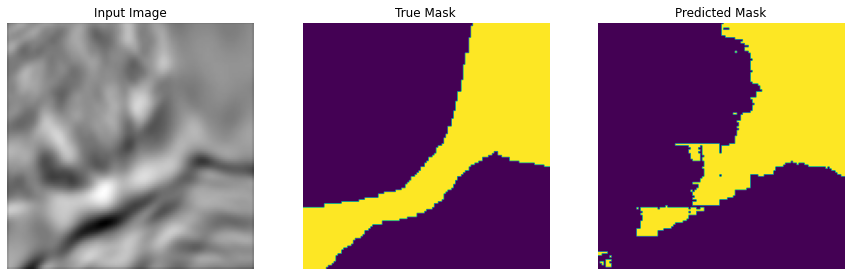


Sample Prediction after epoch 31

13/13 [==============================] - 1s 43ms/step
IOU Score after epoch30 is 0.004692663336974798
Epoch 32/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1169 - accuracy: 0.9528 - val_loss: 0.1442 - val_accuracy: 0.9429
Epoch 33/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1151 - accuracy: 0.9538 - val_loss: 0.1436 - val_accuracy: 0.9412
Epoch 34/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1148 - accuracy: 0.9531 - val_loss: 0.1412 - val_accuracy: 0.9440

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 35/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1148 - accuracy: 0.9540 - val_loss: 0.1330 - val_accuracy: 0.9457
Epoch 36/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1100 - accuracy: 0.9556 - val_loss: 0.1331 - val_accuracy: 0.9454


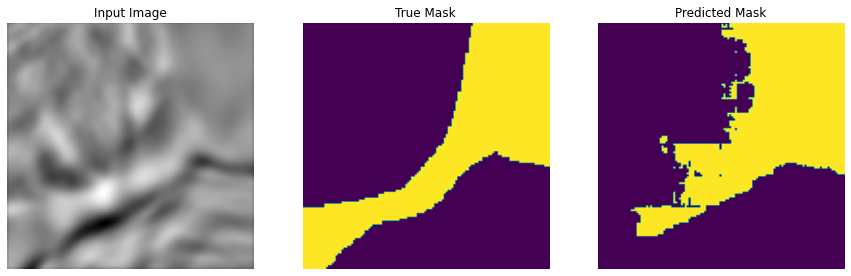


Sample Prediction after epoch 36

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch35 is 0.005303492415398954
Epoch 37/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1123 - accuracy: 0.9539 - val_loss: 0.1326 - val_accuracy: 0.9458
Epoch 38/200
181/181 [==============================] - 25s 141ms/step - loss: 0.1179 - accuracy: 0.9526 - val_loss: 0.1321 - val_accuracy: 0.9458
Epoch 39/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1141 - accuracy: 0.9542 - val_loss: 0.1330 - val_accuracy: 0.9454
Epoch 40/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1098 - accuracy: 0.9559 - val_loss: 0.1324 - val_accuracy: 0.9454
Epoch 41/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1120 - accuracy: 0.9547 - val_loss: 0.1313 - val_accuracy: 0.9459


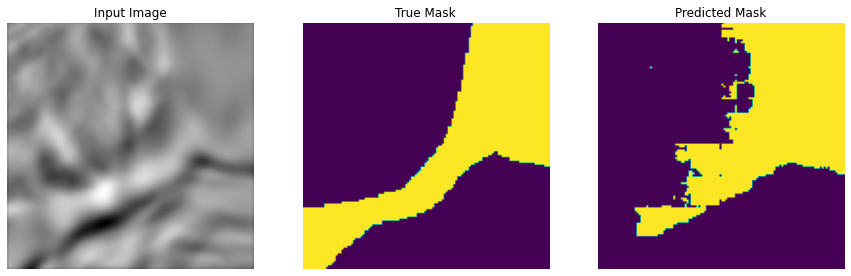


Sample Prediction after epoch 41

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch40 is 0.006051850018562059
Epoch 42/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1117 - accuracy: 0.9551 - val_loss: 0.1317 - val_accuracy: 0.9460
Epoch 43/200
181/181 [==============================] - 25s 141ms/step - loss: 0.1146 - accuracy: 0.9536 - val_loss: 0.1318 - val_accuracy: 0.9459
Epoch 44/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1114 - accuracy: 0.9556 - val_loss: 0.1313 - val_accuracy: 0.9460
Epoch 45/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1102 - accuracy: 0.9557 - val_loss: 0.1316 - val_accuracy: 0.9457
Epoch 46/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1099 - accuracy: 0.9562 - val_loss: 0.1314 - val_accuracy: 0.9458


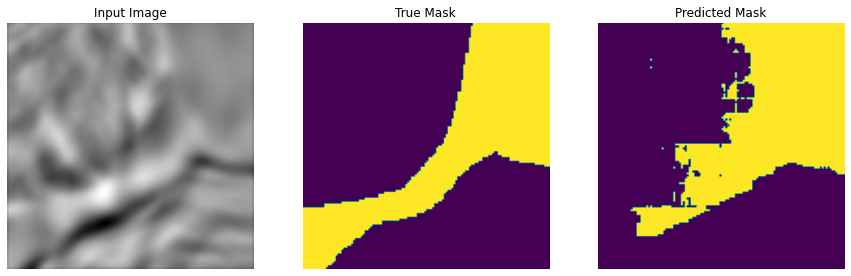


Sample Prediction after epoch 46

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch45 is 0.0057348983795073956

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 47/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1165 - accuracy: 0.9532 - val_loss: 0.1312 - val_accuracy: 0.9460
Epoch 48/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1113 - accuracy: 0.9554 - val_loss: 0.1310 - val_accuracy: 0.9459
Epoch 49/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1107 - accuracy: 0.9554 - val_loss: 0.1309 - val_accuracy: 0.9459
Epoch 50/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1085 - accuracy: 0.9570 - val_loss: 0.1311 - val_accuracy: 0.9459
Epoch 51/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1056 - accuracy: 0.9577 - val_loss: 0.1309 - val_accuracy: 0.9459


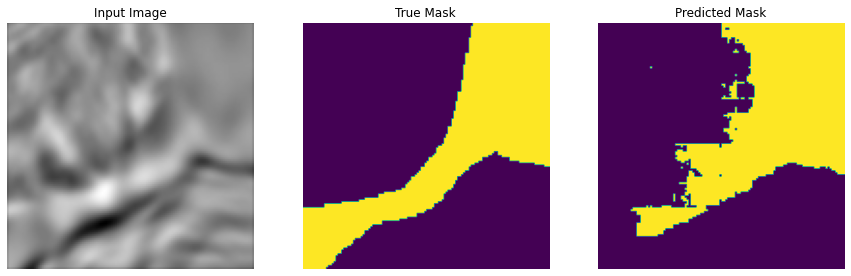


Sample Prediction after epoch 51

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch50 is 0.005558606522106575
Epoch 52/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1076 - accuracy: 0.9569 - val_loss: 0.1308 - val_accuracy: 0.9459
Epoch 53/200
181/181 [==============================] - 26s 142ms/step - loss: 0.1090 - accuracy: 0.9561 - val_loss: 0.1312 - val_accuracy: 0.9458
Epoch 54/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1114 - accuracy: 0.9551 - val_loss: 0.1311 - val_accuracy: 0.9459
Epoch 55/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1096 - accuracy: 0.9560 - val_loss: 0.1310 - val_accuracy: 0.9458
Epoch 56/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1109 - accuracy: 0.9552 - val_loss: 0.1309 - val_accuracy: 0.9460


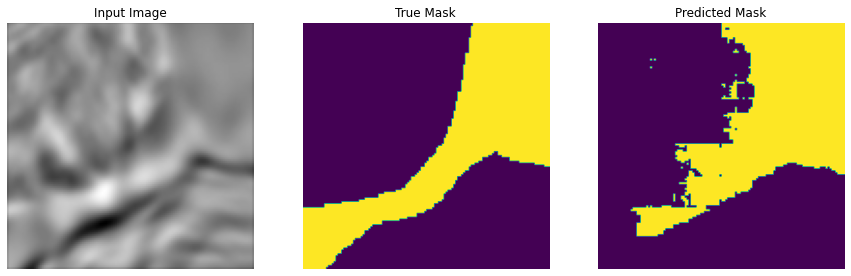


Sample Prediction after epoch 56

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch55 is 0.005655998657961575
Epoch 57/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1100 - accuracy: 0.9556 - val_loss: 0.1310 - val_accuracy: 0.9460

Epoch 00057: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 58/200
181/181 [==============================] - 26s 142ms/step - loss: 0.1100 - accuracy: 0.9555 - val_loss: 0.1310 - val_accuracy: 0.9459
Epoch 59/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1097 - accuracy: 0.9560 - val_loss: 0.1312 - val_accuracy: 0.9459
Epoch 60/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1103 - accuracy: 0.9559 - val_loss: 0.1310 - val_accuracy: 0.9459
Epoch 61/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1085 - accuracy: 0.9562 - val_loss: 0.1312 - val_accuracy: 0.9458


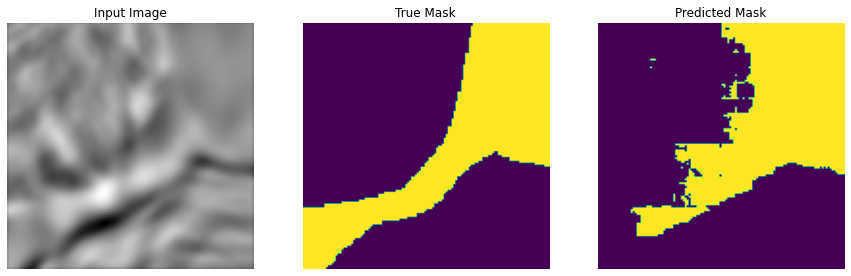


Sample Prediction after epoch 61

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch60 is 0.005835499443000372
Epoch 62/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1090 - accuracy: 0.9559 - val_loss: 0.1311 - val_accuracy: 0.9459

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 63/200
181/181 [==============================] - 25s 141ms/step - loss: 0.1098 - accuracy: 0.9559 - val_loss: 0.1310 - val_accuracy: 0.9459
Epoch 64/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1112 - accuracy: 0.9551 - val_loss: 0.1311 - val_accuracy: 0.9459
Epoch 65/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1090 - accuracy: 0.9564 - val_loss: 0.1310 - val_accuracy: 0.9460
Epoch 66/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1125 - accuracy: 0.9548 - val_loss: 0.1314 - val_accuracy: 0.9458


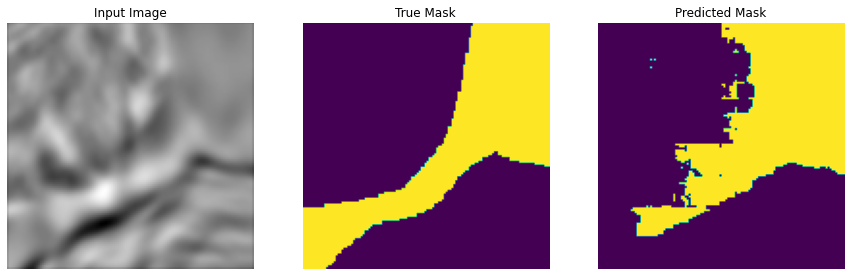


Sample Prediction after epoch 66

13/13 [==============================] - 1s 43ms/step
IOU Score after epoch65 is 0.005619156513659125
Epoch 67/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1098 - accuracy: 0.9557 - val_loss: 0.1312 - val_accuracy: 0.9459

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 68/200
181/181 [==============================] - 26s 141ms/step - loss: 0.1092 - accuracy: 0.9562 - val_loss: 0.1312 - val_accuracy: 0.9459
Epoch 69/200
181/181 [==============================] - 25s 138ms/step - loss: 0.1089 - accuracy: 0.9562 - val_loss: 0.1312 - val_accuracy: 0.9459
Epoch 70/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1107 - accuracy: 0.9555 - val_loss: 0.1312 - val_accuracy: 0.9459
Epoch 71/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1096 - accuracy: 0.9561 - val_loss: 0.1311 - val_accuracy: 0.9459


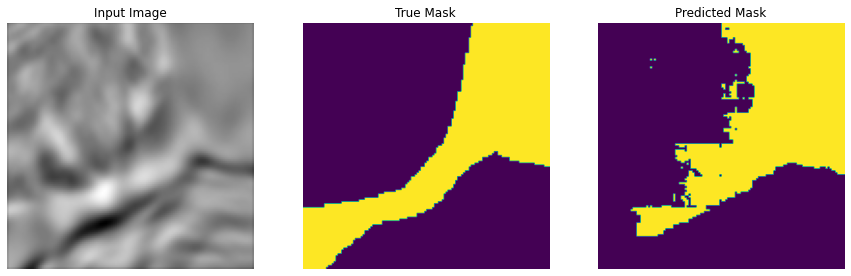


Sample Prediction after epoch 71

13/13 [==============================] - 1s 43ms/step
IOU Score after epoch70 is 0.005604344310906464
Epoch 72/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1111 - accuracy: 0.9556 - val_loss: 0.1313 - val_accuracy: 0.9459

Epoch 00072: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 73/200
181/181 [==============================] - 25s 141ms/step - loss: 0.1090 - accuracy: 0.9562 - val_loss: 0.1313 - val_accuracy: 0.9459
Epoch 74/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1116 - accuracy: 0.9553 - val_loss: 0.1312 - val_accuracy: 0.9459
Epoch 75/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1135 - accuracy: 0.9541 - val_loss: 0.1313 - val_accuracy: 0.9459
Epoch 76/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1099 - accuracy: 0.9556 - val_loss: 0.1313 - val_accuracy: 0.9459


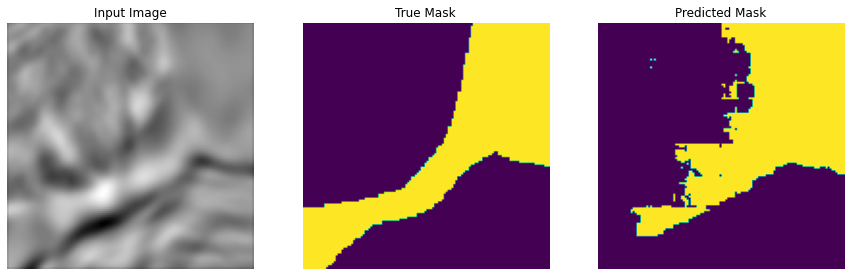


Sample Prediction after epoch 76

13/13 [==============================] - 1s 44ms/step
IOU Score after epoch75 is 0.005766028953932425
Epoch 77/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1103 - accuracy: 0.9553 - val_loss: 0.1312 - val_accuracy: 0.9459

Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 78/200
181/181 [==============================] - 26s 141ms/step - loss: 0.1093 - accuracy: 0.9561 - val_loss: 0.1313 - val_accuracy: 0.9459
Epoch 79/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1092 - accuracy: 0.9561 - val_loss: 0.1314 - val_accuracy: 0.9459
Epoch 80/200
181/181 [==============================] - 25s 139ms/step - loss: 0.1081 - accuracy: 0.9565 - val_loss: 0.1313 - val_accuracy: 0.9459
Epoch 81/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1077 - accuracy: 0.9567 - val_loss: 0.1312 - val_accuracy: 0.9459


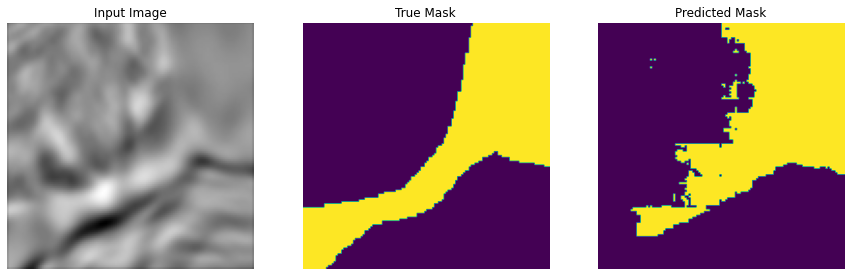


Sample Prediction after epoch 81

13/13 [==============================] - 1s 43ms/step
IOU Score after epoch80 is 0.005526377213940637
Epoch 82/200
181/181 [==============================] - 25s 140ms/step - loss: 0.1094 - accuracy: 0.9561 - val_loss: 0.1313 - val_accuracy: 0.9458
Restoring model weights from the end of the best epoch.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 00082: early stopping


In [ ]:
EPOCHS = 200
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_eval)//BATCH_SIZE//VAL_SUBSPLITS

es = callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-12, verbose=1)

save_model_weights = [
    tf.keras.callbacks.ModelCheckpoint("Salt_Identification.h5", save_best_only=True)
]


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), es, rlp, save_model_weights])

In [ ]:
def seg_metrics(y_true, y_pred, metric_name,
    metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """
    Compute mean metrics of two segmentation masks, via Keras.

    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)

    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.

    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """

    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')

    # always assume one or more classes
    num_classes = K.shape(y_true)[-1]

    if not flag_soft:
        # get one-hot encoded masks from y_pred (true masks should already be one-hot)
        y_pred = K.one_hot(K.argmax(y_pred), num_classes)
        y_true = K.one_hot(K.argmax(y_true), num_classes)

    # if already one-hot, could have skipped above command
    # keras uses float32 instead of float64, would give error down (but numpy arrays or keras.to_categorical gives float64)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = K.sum(K.abs(y_true * y_pred), axis=axes)
    mask_sum = K.sum(K.abs(y_true), axis=axes) + K.sum(K.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2 * (intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  K.cast(K.not_equal(union, 0), 'float32')

    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]

    if verbose:
        print('intersection, union')
        print(K.eval(intersection), K.eval(union))
        print(K.eval(intersection/union))

    # return mean metrics: remaining axes are (batch, classes)
    if flag_naive_mean:
        return K.mean(metric)

    # take mean only over non-absent classes
    class_count = K.sum(mask, axis=0)
    non_zero = tf.greater(class_count, 0)
    non_zero_sum = tf.boolean_mask(K.sum(metric * mask, axis=0), non_zero)
    non_zero_count = tf.boolean_mask(class_count, non_zero)

    if verbose:
        print('Counts of inputs with class present, metrics for non-absent classes')
        print(K.eval(class_count), K.eval(non_zero_sum / non_zero_count))

    return K.mean(non_zero_sum / non_zero_count)

def mean_iou(y_true, y_pred, **kwargs):
    """
    Compute mean Intersection over Union of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='iou', **kwargs)

def mean_dice(y_true, y_pred, **kwargs):
    """
    Compute mean Dice coefficient of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='dice', **kwargs)

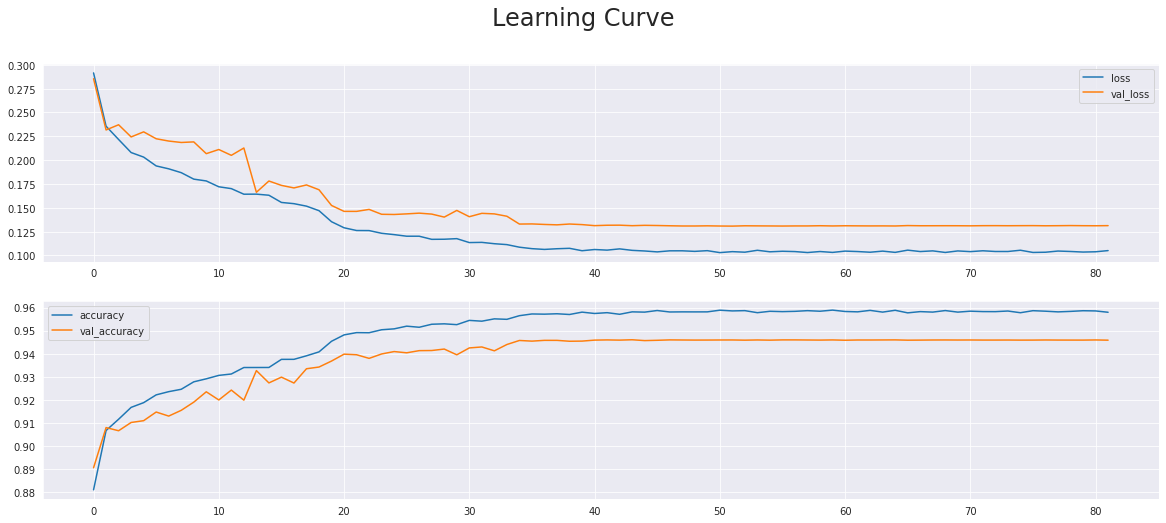

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
history = pd.DataFrame(model_history.history)
history[['loss', 'val_loss']].plot(ax=ax[0])
history[['accuracy', 'val_accuracy']].plot(ax=ax[1])
fig.suptitle('Learning Curve', fontsize=24);

In [ ]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
# preds_eval = model.predict(X_eval, verbose=1)
# preds_eval= np.array(tf.argmax(preds_eval, axis=-1)[..., tf.newaxis])

# thresholds = np.linspace(0, 1, 50)
# ious = np.array([iou_metric_batch(np.array(Y_eval), np.int32(preds_eval > threshold)) for threshold in tqdm(thresholds)])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
# iou_best = ious[threshold_best_index]
# threshold_best = thresholds[threshold_best_index]

# plt.plot(thresholds, ious)
# plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
# plt.xlabel("Threshold")
# plt.ylabel("IoU")
# plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
# plt.legend();

In [ ]:
intersection=np.histogram2d(Y_eval.numpy().flatten(), np.expand_dims(np.argmax(model.predict(X_eval, verbose=1),axis=-1),axis=-1).flatten(), bins=(2, 2))[0]

13/13 [==============================] - 1s 50ms/step


In [ ]:

labels = Y_eval.numpy()
y_pred = np.expand_dims(np.argmax(model.predict(X_eval, verbose=1),axis=-1),axis=-1)

true_objects = 2
pred_objects = 2
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

# Compute areas (needed for finding the union between all objects)
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

# Compute union
union = area_true + area_pred - intersection

# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

# Compute the intersection over union
iou = intersection / union  

13/13 [==============================] - 1s 41ms/step


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(epoch_history,np.array(iou_history)*10)
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.title('IOU score on Validation Data')